In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
precip_analysis = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-24").\
    filter(Measurement.date <= "2017-08-23").all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_analysis)

# Sort the dataframe by date
precip_df['date'] = pd.to_datetime(precip_df['date'])
precip_df = precip_df.set_index('date')                                      
precip_df.rename(columns = {'prcp': 'precipitation'}, inplace=True)          
precip_df.head()



,precipitation
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


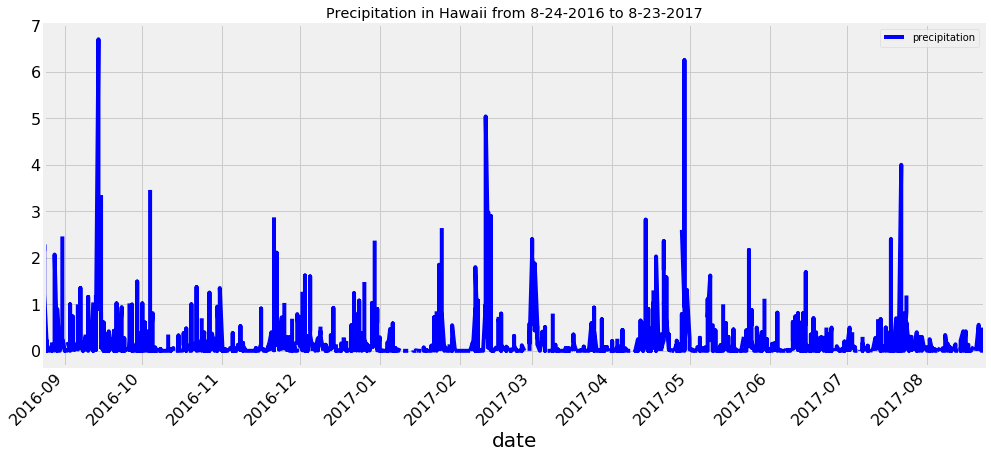

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(figsize=(15, 7),                                              
               sort_columns=True, 
               rot=45, 
               use_index=True, 
               title='Precipitation in Hawaii from 8-24-2016 to 8-23-2017', 
               legend=True,
               fontsize=16,
               grid=True,
               color='blue'
              )

plt.xlabel('date', fontsize=20)
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).count() 
print(f"stations available in Hawaii:{station_count}")

stations available in Hawaii:9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

station_activity

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
results = session.query(func.avg(Measurement.tobs), func.max(Measurement.tobs), func.min(Measurement.tobs)).\
        filter(Station.station == 'USC00519281').all()
print(results)

[(73.09795396419437, 87.0, 53.0)]


In [24]:
# Choose the station with the highest number of temperature observations.
station_activity[0]  


('USC00519281', 'WAIHEE 837.5, HI US', 2772)

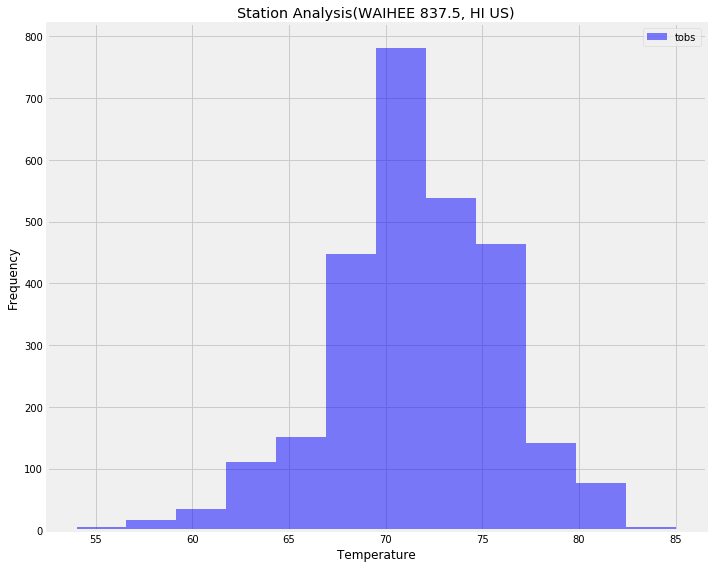

In [27]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature = session.query(Measurement.tobs).\
              filter(Station.station == Measurement.station).\
              filter(Station.name == 'WAIHEE 837.5, HI US').all()
        
tobs_df = pd.DataFrame(temperature, columns=['tobs'])

fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(tobs_df['tobs'], bins=12, color='blue', alpha=0.5)
ax.legend(['tobs'])
ax.set_title('Station Analysis(WAIHEE 837.5, HI US)')
ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.savefig("station_analysis.png", box_inches='tight')
plt.show()

In [38]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
#return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        #filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    
    
# function usage example

def calc_temps(start_date, end_date):
    min_temp = session.query(func.min(Measurement.tobs)).\
               filter(Measurement.date.between(start_date, end_date)).all()
    max_temp = session.query(func.max(Measurement.tobs)).\
               filter(Measurement.date.between(start_date, end_date)).all()
    avg_temp = session.query(func.avg(Measurement.tobs)).\
               filter(Measurement.date.between(start_date, end_date)).all()
    result = min_temp, max_temp, avg_temp
    return list(np.ravel(result))
print(calc_temps('2012-02-28', '2012-03-05'))

[62.0, 74.0, 69.57142857142857]


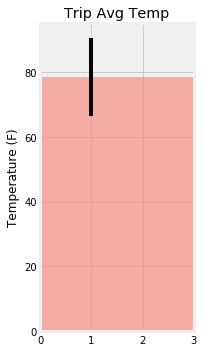

In [56]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = dt.datetime(2017, 7, 17)
end_date = dt.datetime(2017, 7, 27)
temp_data = calc_temps(start_date, end_date)
Max = temp_data[0]
Min = temp_data[1]
Avg = temp_data[2]
plt.figure(figsize=(3,5))                                                    
plt.bar(x=1, height= Avg, width=4, yerr=Max-Min, color='salmon', alpha=0.6)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
plt.xlim(0,3)
plt.tight_layout()
plt.show()